## Notebook contains my attempts to recreate river system from correlations of water levels on hydrological posts

### Step 0: import and load

In [1]:
# !pipenv shell
# !pipenv --where
# !python --version

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import pandas as pd

import geopandas as gpd
import geoplot as glpt
from shapely.geometry import Point, LineString

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import pickle


In [3]:
SHIFTS = np.arange(-5, 1)
root_dir = "../"
data_dir = os.path.join(root_dir, "working_data/")

water_levels_path = os.path.join(data_dir, "water_levels.csv")
hydro_coords_path = os.path.join(data_dir, "hydro_posts_coords.csv")

In [4]:
water_levels = pd.read_csv(water_levels_path)
water_levels["date"] = pd.to_datetime(water_levels["date"], format="%Y-%m-%d")
water_levels.set_index(["id", "date"], inplace=True)

hydro_coords = pd.read_csv(hydro_coords_path, index_col=0)
hydro_coords = gpd.GeoDataFrame(hydro_coords, geometry=gpd.points_from_xy(hydro_coords["longitude"], hydro_coords["latitude"]))
hydro_coords.sort_values(by="id", inplace=True)

In [5]:
water_levels.head()
hydro_coords.head()

max_level
id   date                 
5001 1984-01-01      258.0
     1984-01-02      255.0
     1984-01-03      252.0
     1984-01-04      248.0
     1984-01-05      244.0

,latitude,longitude,geometry
id,,,
5001.0,47.733333,130.970000,POINT (130.97000 47.73333)
5002.0,47.737389,131.533972,POINT (131.53397 47.73739)
5004.0,47.930000,132.480000,POINT (132.48000 47.93000)
5008.0,48.450000,134.520000,POINT (134.52000 48.45000)
5009.0,48.270000,134.720000,POINT (134.72000 48.27000)


### Step 1: idk

(array([1.52158019e-05, 1.52158019e-05, 1.52158019e-05, 1.14118514e-05,
        1.90197524e-05, 1.90197524e-05, 2.28237029e-05, 7.98829601e-05,
        1.55961970e-04, 3.99414800e-04]),
 array([   92. ,  1419.7,  2747.4,  4075.1,  5402.8,  6730.5,  8058.2,
         9385.9, 10713.6, 12041.3, 13369. ]),
 <BarContainer object of 10 artists>)

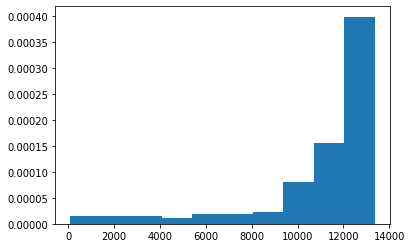

0.1 quantile of records count is: 6923.9000000000015


In [6]:
# check distribution of records number for ids
count_records = water_levels.groupby("id").count()#.values
plt.hist(count_records, density=True)
plt.show()

quantile = 0.1
print(f"{quantile} quantile of records count is: {count_records['max_level'].quantile(quantile)}")

In [7]:
hydro_ids = water_levels.index.get_level_values("id").unique()
hydro_number = len(hydro_ids)
print(f"Total hydrological posts amount: {hydro_number}")

Total hydrological posts amount: 198


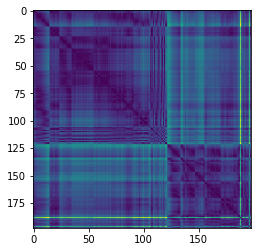

In [8]:
def calc_euclidean_distance(sample, pairs_arr):
    return (((sample - pairs_arr) ** 2).sum(axis=1))**0.5

def calc_distances_with_all_hydro_points(sample):
    coords = sample[["latitude", "longitude"]]
    df_coords = hydro_coords[["latitude", "longitude"]]
    return calc_euclidean_distance(coords, df_coords)

def calc_coordinate_distance_matrix(df):
    return df.apply(lambda x: calc_distances_with_all_hydro_points(x), axis=1)

hydro_distances = calc_coordinate_distance_matrix(hydro_coords)
plt.imshow(hydro_distances)

In [9]:
def calc_correlation_matrix(df, shifts):
    corr_results = np.full((len(shifts), hydro_number, hydro_number), np.nan, dtype=float)
    
    for shift_idx, shift in enumerate(shifts):
        for idx_first_post, hydro_post in tqdm(enumerate(hydro_ids), total=hydro_number): 
            sample = df.loc[hydro_post, "max_level"]
            shifted_sample = shift_date_index(sample, shift)
            
            filtered_df = preprocess_df_for_corr(sample, df)
            correlations = calc_correlations(sample, filtered_df)
            
            for (second_post, corr_value) in correlations.items():
                idx_second_post = hydro_ids.get_loc(second_post)
                corr_results[shift_idx, idx_first_post, idx_second_post] = corr_value
                
    return corr_results


def shift_date_index(df, days, copy=False):
    if copy:
        df = df.copy()
    df.index += pd.to_timedelta(days, unit='d')
    return df


def preprocess_df_for_corr(sample, df, min_records=70):
#     right_triangle_df = filter_min_id(df, hydro_post) # keep only right triangle of matrix to reduce computational time
    right_dates = sample.index
    df_same_dates = filter_dates(df, right_dates)
    df_enough_records = filter_min_records_count(df_same_dates, min_records)
    
    return df_enough_records


def calc_correlations(first_hydro_post, all_hydro_posts):
    post_ids = get_ids(all_hydro_posts).unique()
    correlations = {}
    
    for second_post_id in post_ids:
        second_hydro_post = all_hydro_posts.loc[second_post_id, "max_level"]

        corr = first_hydro_post.corr(second_hydro_post)
        correlations[second_post_id] = corr
        
    return correlations


def filter_dates(df, right_dates):
    df_dates = get_dates(df)
    date_correct_mask = df_dates.isin(right_dates)
    df = df[date_correct_mask]
    return df


def filter_min_records_count(df, min_count):
    df_ids = get_ids(df)
    records_by_id = df_ids.value_counts()
    
    df_filtered_ids = records_by_id[records_by_id >= min_count].index
    df = df[df_ids.isin(df_filtered_ids)]
    return df


def get_ids(df):
    return df.index.get_level_values("id")

def get_dates(df):
    return df.index.get_level_values("date")


# corr_results = calc_correlation_matrix(water_levels, SHIFTS)

In [10]:
# with open(os.path.join(data_dir, "correlations.pkl"), "wb") as f:
#     pickle.dump(corr_results, f)

In [11]:
with open(os.path.join(data_dir, "correlations.pkl"), "rb") as f:
    corr_results = pickle.load(f)

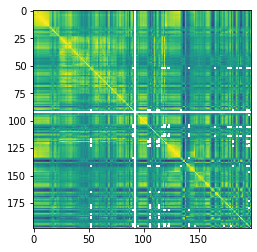

In [12]:
# corr_results[corr_results == -999] = np.nan
plt.imshow(corr_results[-1])

In [13]:
def set_diag_val(array, value):
    diag_mask = np.diag(np.ones(array.shape[-1], dtype=bool))
    array[diag_mask] = value
    return array

In [14]:
def find_nearest_posts(posts, distance_matrix):
    distance_matrix = set_diag_val(distance_matrix, np.nan)
    post_to_nearest = {}
    
    for post in posts:
        nearest = min_idx(distance_matrix[post])  
        post_to_nearest[post] = {"nearest_post": nearest}
        
    nearest_posts = pd.DataFrame.from_dict(data=post_to_nearest, orient="index")
    nearest_posts.index.name = "post"
    return nearest_posts
    
        
def min_idx(arr):
    min_val_idx = np.nanargmin(arr)
    arr_idx_min_val = arr.index[min_val_idx]
    return arr_idx_min_val


nearest_posts = find_nearest_posts(hydro_distances, hydro_distances)
nearest_posts.head()

,nearest_post
post,
5001.0,5036.0
5002.0,5036.0
5004.0,5675.0
5008.0,5358.0
5009.0,5008.0


In [15]:
def get_far_points_mask(distances, max_val):
    mask_far_points = distances > max_val
    return mask_far_points

In [16]:
def get_posts_not_in_dict(posts, dct):
    not_in_dct = [post for post in posts if post not in dct.keys()]
    return not_in_dct

In [17]:
def find_most_corr_posts(posts, corr_matrix, shifts, distances, max_dist=8):
    post_to_parent = {}
    corr_matrix = corr_matrix.copy() # copy to prevent modyfying
    
    corr_matrix = set_diag_val_3d(corr_matrix, np.nan)
    mask_far_points = get_far_points_mask(distances, max_dist)
    corr_matrix[:, mask_far_points] = np.nan
    
    while get_posts_not_in_dict(posts, post_to_parent):
        if check_arr_only_nan(corr_matrix):
            break
            
        shift_idx, shifted_post, parent_post = max_coords_3d(corr_matrix)
        shift = shifts[shift_idx]
        
        
        if check_no_zero_loop(post_to_parent, shift, shifted_post, parent_post):
            post_to_parent[shifted_post] = {"id": parent_post, "shift": shift}
            corr_matrix[:, shifted_post, :] = np.nan
            
#             corr_matrix[:, parent_post, shifted_post] = np.nan
            
    top_corrs = pd.DataFrame.from_dict(data=post_to_parent, orient="index")
    top_corrs.index.name = "post"
    top_corrs.rename(columns={"id": "best_corr_idx"}, inplace=True)
    
    return top_corrs


def check_no_zero_loop(post_to_parent, shift, post, parent_post):
    total_shift = shift
    visited = [post]
    
    while post in post_to_parent:
        parent_post, shift = post_to_parent[post]["id"], post_to_parent[post]["shift"]
        total_shift += shift
        
        if parent_post in visited:
            if total_shift == 0:
                return False
            else:
                return True
            
        visited.append(parent_post)
        post = parent_post
        
            
    return True


def max_coords_3d(array):
    max_val = np.nanmax(array) #if using ordinal max, produces nan
    return np.argwhere(array == max_val)[0]


def check_arr_only_nan(arr):
    if np.sum(~np.isnan(arr)):
        return False
    return True


def set_diag_val_3d(array, value):
    diag_mask = np.diag(np.ones(array.shape[-1], dtype=bool))
    array[:, diag_mask] = value
    return array

top_corrs = find_most_corr_posts(hydro_ids, corr_results, SHIFTS, hydro_distances, max_dist=2.2)
top_corrs.head()

,best_corr_idx,shift
post,,
41,119,0
119,41,0
5,6,0
6,5,0
32,33,0


In [18]:
index_post_ids = top_corrs.index.to_series().apply(lambda x: hydro_ids[x])
top_corrs.index = index_post_ids

best_corr_ids = top_corrs["best_corr_idx"].apply(lambda x: hydro_ids[x])
top_corrs["best_corr_idx"] = best_corr_ids
top_corrs.rename(columns={"best_corr_idx": "best_corr_post", "shift": "best_corr_shift"}, inplace=True)

corr_and_nearest = top_corrs.merge(nearest_posts, how="right", on="post")
corr_and_nearest.head()

,best_corr_post,best_corr_shift,nearest_post
post,,,
5001,5002.0,0.0,5036.0
5002,6030.0,-1.0,5036.0
5004,5008.0,0.0,5675.0
5008,5004.0,-2.0,5358.0
5009,5012.0,0.0,5008.0


In [19]:
def values_to_idxs(seq, values):
    if not isinstance(seq, pd.Series):
        seq = pd.Series(seq)
    seq = pd.Index(seq)    
    
    return [seq.get_loc(val) if not np.isnan(val) else np.nan for val in values]


def get_arr_values_by_idxs(arr, idxs):
    vals = []
    for val_idx in idxs:
        if np.isnan(val_idx).any():
            val = np.nan
        
        else:
            val_idx = tuple([int(idx) for idx in val_idx])
            val = arr[val_idx]
            
        vals.append(val)
        
    return vals

def get_distances(distances, first_posts, second_posts):
    first_posts = values_to_idxs(hydro_ids, first_posts)
    second_posts = values_to_idxs(hydro_ids, second_posts)
    
    dist_idxs = zip(first_posts, second_posts)
    return get_arr_values_by_idxs(distances.values, dist_idxs)

    
    
def get_correlations(correlations, first_posts, second_posts, shifts):
    first_posts = values_to_idxs(hydro_ids, first_posts)
    second_posts = values_to_idxs(hydro_ids, second_posts)
    shifts = values_to_idxs(SHIFTS, shifts)
    
    corr_idxs = zip(shifts, first_posts, second_posts)
    return get_arr_values_by_idxs(correlations, corr_idxs)
    
corr_and_nearest["nearest_shift"] = np.full(len(corr_and_nearest), -1)
    
corr_and_nearest["best_corr_dist"] = get_distances(hydro_distances, corr_and_nearest.index, corr_and_nearest["best_corr_post"])
corr_and_nearest["best_corr_value"] = get_correlations(corr_results, corr_and_nearest.index,
                                                       corr_and_nearest["best_corr_post"], corr_and_nearest["best_corr_shift"])

corr_and_nearest["nearest_dist"] = get_distances(hydro_distances, corr_and_nearest.index, corr_and_nearest["nearest_post"])
corr_and_nearest["nearest_corr"] = get_correlations(corr_results, corr_and_nearest.index,
                                                       corr_and_nearest["nearest_post"], corr_and_nearest["nearest_shift"])

corr_and_nearest.head()

,best_corr_post,best_corr_shift,nearest_post,nearest_shift,best_corr_dist,best_corr_value,nearest_dist,nearest_corr
post,,,,,,,,
5001,5002.0,0.0,5036.0,-1,0.563987,0.955423,0.277389,0.483945
5002,6030.0,-1.0,5036.0,-1,1.444206,0.970280,0.317767,0.494123
5004,5008.0,0.0,5675.0,-1,2.105232,0.969865,0.200250,-0.115904
5008,5004.0,-2.0,5358.0,-1,2.105232,0.978104,0.254951,0.793771
5009,5012.0,0.0,5008.0,-1,0.407063,0.946303,0.269072,0.891186


In [23]:
corr_and_nearest.to_csv(data_dir + "corrs_and_dists.csv")

In [20]:
num_nearest_equals_best_corr = sum(corr_and_nearest["best_corr_post"] == corr_and_nearest["nearest_post"])
print(f"In {num_nearest_equals_best_corr} of {hydro_number} cases nearest point is also the point with best correlation")

In 40 of 198 cases nearest point is also the point with best correlation


<AxesSubplot:>

<AxesSubplot:>

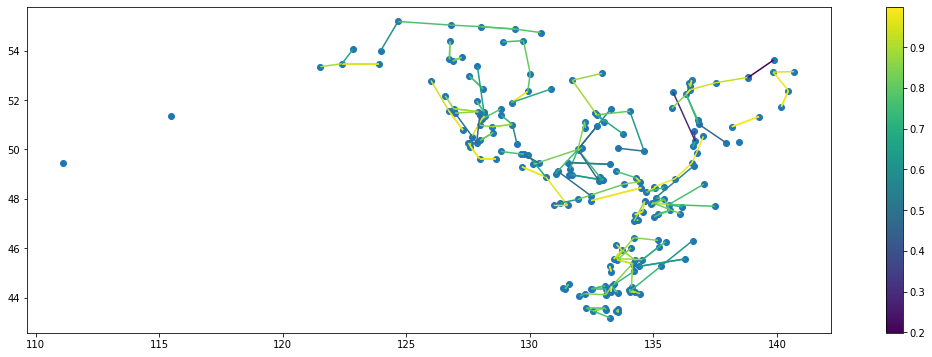

In [21]:
# 1: plot points
# 2: plot lines and color respectivaly to corr value
fig = plt.figure(figsize=(20, 6))
subplot = fig.add_subplot(111)

hydro_coords.plot(ax=subplot)

corrs = []
lines = []

for (post_id1, col_values) in corr_and_nearest.iterrows():
    post_id2 = col_values["best_corr_post"]
    corr = col_values["best_corr_value"]

    if np.isnan(post_id2):
        continue
    
    coord1, coord2 = hydro_coords.loc[post_id1, "geometry"], hydro_coords.loc[post_id2, "geometry"]
    line = LineString([(coord1.x, coord1.y), (coord2.x, coord2.y)]) #debug and ues coord1.x, coord1.y in case of errors
    
    lines.append(line)
    corrs.append(corr)
    
lines_with_corrs = gpd.GeoDataFrame(zip(lines, corrs), columns=["lines", "corrs"], geometry="lines")
lines_with_corrs.plot(column="corrs", ax=subplot, legend=True)

plt.savefig(data_dir + "correlations_between_hydro_points")